In [37]:
import uuid
import pandas as pd
import numpy as np
from untrade.client import Client
import os

In [38]:
TRANSACTION_COST = 0.0015  # 0.15% per transaction
RISK_TOLERANCE = 0.02  # 2% risk per trade
RISK_FREE_RATE = 0.01  # annualized risk-free rate for Sharpe Ratio
TARGET_PROFIT_PERCENTAGE = 0.05  # Target profit percentage (5%)

In [39]:
def process_data(data):
    data['datetime'] = pd.to_datetime(data['datetime'])
    data = data[(data['datetime']>='2020-01-01') & (data['datetime']<='2023-12-31')].copy()
    # Calculate indicators
    data["ema_20"] = data["close"].ewm(span=20, adjust=False).mean()
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data["rsi"] = 100 - (100 / (1 + rs))
    ema_short = data['close'].ewm(span=24, adjust=False).mean()
    ema_long = data['close'].ewm(span=52, adjust=False).mean()
    data["macd"] = ema_short - ema_long
    data["signal_line"] = data["macd"].ewm(span=18, adjust=False).mean()

    # Generate buy/sell signals
    data["Signal"] = 0
    data.loc[(data["rsi"] < 30) & (data["macd"] > data["signal_line"]) & (data["close"] > data["ema_20"]), "Signal"] = -1
    data.loc[(data["rsi"] > 70) & (data["macd"] < data["signal_line"]) & (data["close"] < data["ema_20"]), "Signal"] = 1  

    #data["Signal"] = 0
    #data.loc[(data["rsi"] < 30) & (data["macd"] > data["signal_line"]) , "Signal"] = 1
    #data.loc[(data["rsi"] > 70) & (data["macd"] < data["signal_line"]) , "Signal"] = -1 
    return data

In [40]:
def strat(data):
    """
    Create a strategy based on indicators or other factors.

    Parameters:
    - data: DataFrame
        The input data containing the necessary columns for strategy creation.

    Returns:
    - DataFrame
        The modified input data with an additional 'signal' column representing the strategy signals.
    """
    signal = []
    prev = None
    for value in data["Signal"]:
        if value == prev:
            signal.append(0)
        else:
            signal.append(value)
        prev = value

    data["signals"] = signal
    return data

In [41]:
def perform_backtest(csv_file_path):
    client = Client()
    result = client.backtest(
        jupyter_id="haricharan",  # the one you use to login to jupyter.untrade.io
        file_path=csv_file_path,
        leverage=1,  # Adjust leverage as needed
    )
    return result

In [42]:
def perform_backtest_large_csv(csv_file_path):
     client = Client()
     file_id = str(uuid.uuid4())
     chunk_size = 90 * 1024 * 1024
     total_size = os.path.getsize(csv_file_path)
     total_chunks = (total_size + chunk_size - 1) // chunk_size
     chunk_number = 0
     if total_size <= chunk_size:
         total_chunks = 1
         # Normal Backtest
         result = client.backtest(
             file_path=csv_file_path,
             leverage=1,
             jupyter_id="test",
             # result_type="Q",
         )
         for value in result:
             print(value)

         return result

     with open(csv_file_path, "rb") as f:
         while True:
             chunk_data = f.read(chunk_size)
             if not chunk_data:
                 break
             chunk_file_path = f"/tmp/{file_id}_chunk_{chunk_number}.csv"
             with open(chunk_file_path, "wb") as chunk_file:
                 chunk_file.write(chunk_data)

             # Large CSV Backtest
             result = client.backtest(
                 file_path=chunk_file_path,
                 leverage=1,
                 jupyter_id="test",
                 file_id=file_id,
                 chunk_number=chunk_number,
                 total_chunks=total_chunks,
                 # result_type="Q",
             )

             for value in result:
                 print(value)

             os.remove(chunk_file_path)

             chunk_number += 1

     return result

In [43]:
def main():
     data = pd.read_csv("BTC_30m.csv")

     processed_data = process_data(data)

     result_data = strat(processed_data)

     csv_file_path = "BTCresults.csv"

     result_data.to_csv(csv_file_path, index=False)

     backtest_result = perform_backtest_large_csv(csv_file_path)
     # backtest_result = perform_backtest(csv_file_path)

     # No need to use following code if you are using perform_backtest_large_csv
     print(backtest_result)
     for value in backtest_result:
         print(value)


if __name__ == "__main__":
    main()

data: {
  "jupyter_id": "test",
  "result_type": "Main",
  "message": "Backtest completed",
  "result": {
    "static_statistics": {
      "From": "2020-01-01 00:00:00",
      "Total Trades": 13,
      "Leverage Applied": 1.0,
      "Winning Trades": 6,
      "Losing Trades": 7,
      "No. of Long Trades": 11,
      "No. of Short Trades": 2,
      "Benchmark Return(%)": 489.663653,
      "Benchmark Return(on $1000)": 4896.636532,
      "Win Rate": 46.153846,
      "Winning Streak": 3,
      "Losing Streak": 3,
      "Gross Profit": 3778.537731,
      "Net Profit": 3759.037731,
      "Average Profit": 289.156749,
      "Maximum Drawdown(%)": 14.546105,
      "Average Drawdown(%)": 5.967219,
      "Largest Win": 3311.651103,
      "Average Win": 764.210115,
      "Largest Loss": -580.719673,
      "Average Loss": -118.031851,
      "Maximum Holding Time": "344 days 23:29:59",
      "Average Holding Time": "74 days 10:53:4",
      "Maximum Adverse Excursion": 62.321555,
      "Average Adv

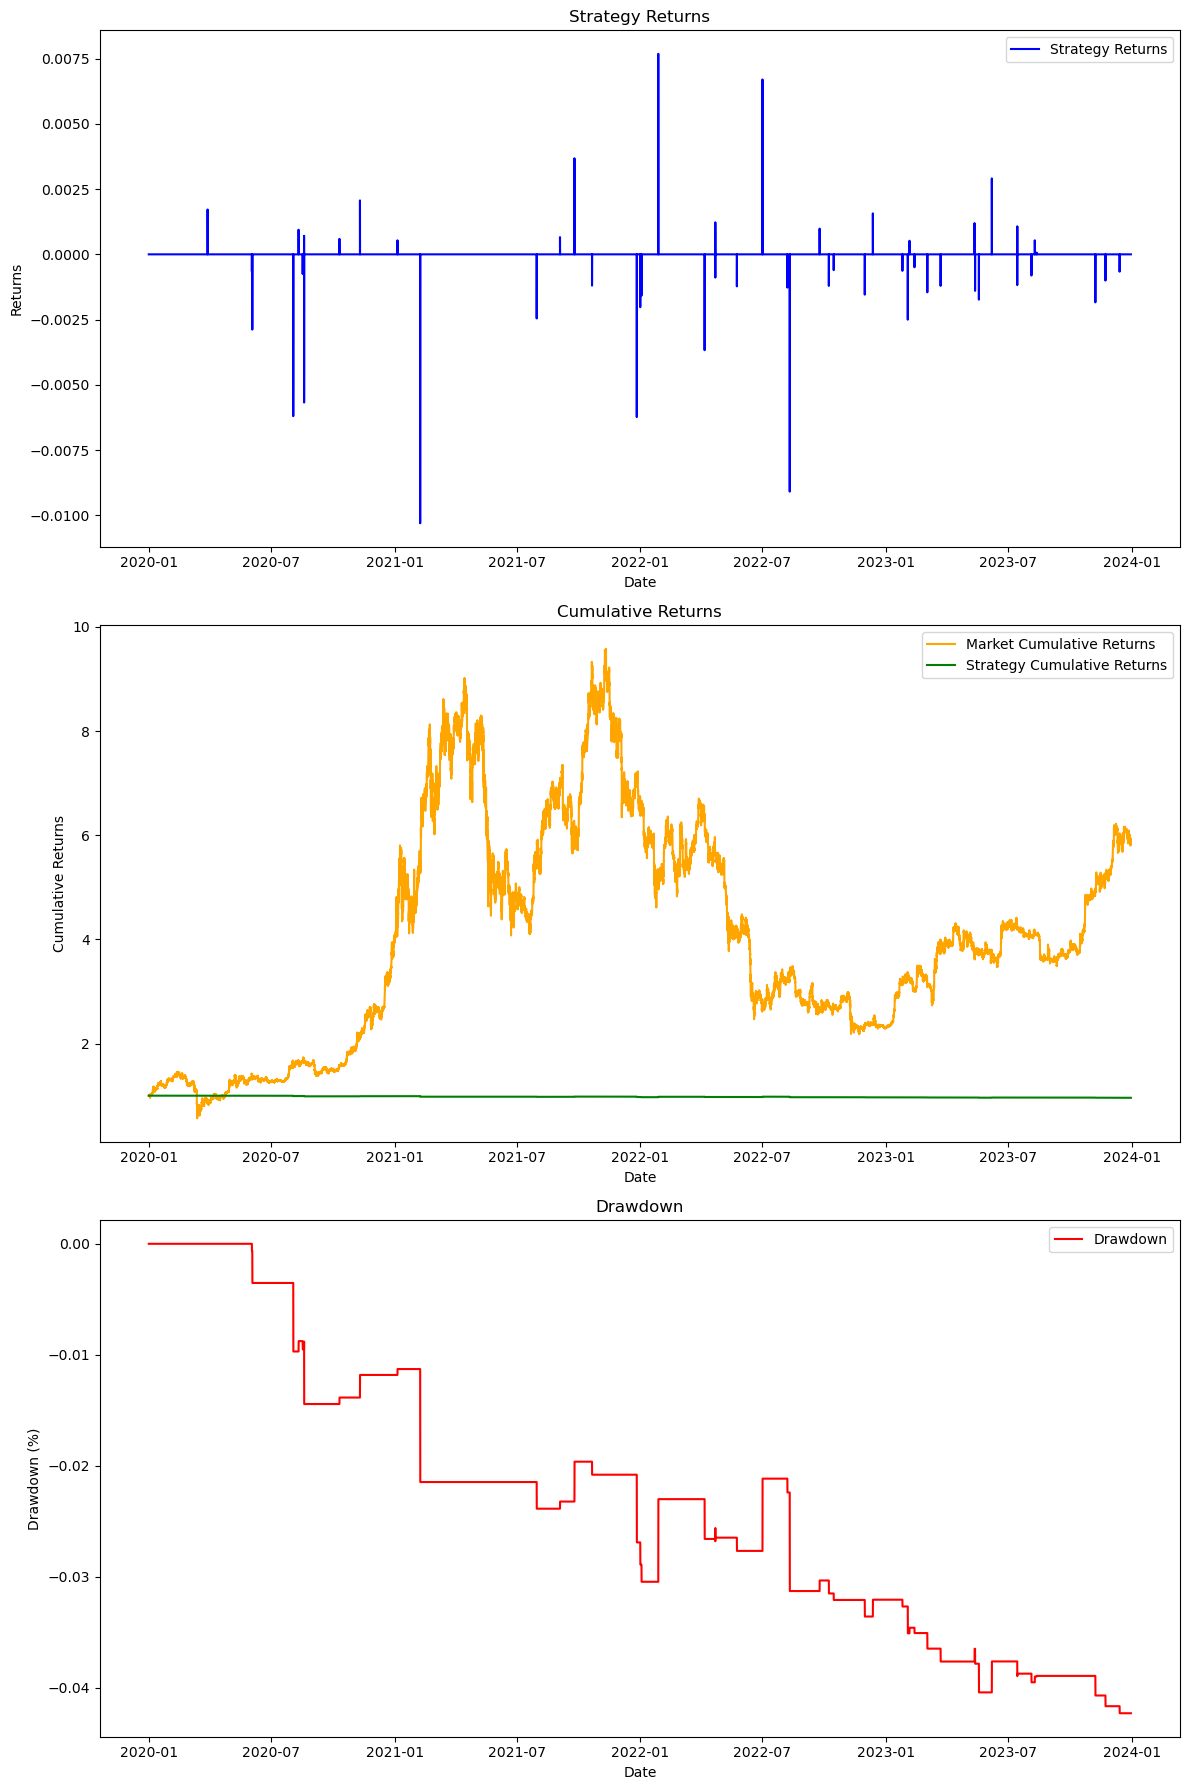

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("BTCresults.csv")
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)


data['returns'] = data['close'].pct_change()
data['strategy_returns'] = data['Signal'].shift(1) * data['returns'] 

data['cumulative_market_returns'] = (1 + data['returns']).cumprod()
data['cumulative_strategy_returns'] = (1 + data['strategy_returns']).cumprod()

data['cum_max'] = data['cumulative_strategy_returns'].cummax()
data['drawdown'] = data['cumulative_strategy_returns'] / data['cumulative_strategy_returns'].cummax() - 1

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))


ax1.plot(data.index, data['strategy_returns'], color="blue", label="Strategy Returns")
ax1.set_title("Strategy Returns")
ax1.set_xlabel("Date")
ax1.set_ylabel("Returns")
ax1.legend()

ax2.plot(data.index, data['cumulative_market_returns'], label="Market Cumulative Returns", color="orange")
ax2.plot(data.index, data['cumulative_strategy_returns'], label="Strategy Cumulative Returns", color="green")
ax2.set_title("Cumulative Returns")
ax2.set_xlabel("Date")
ax2.set_ylabel("Cumulative Returns")
ax2.legend()

# 3. Plot Drawdown
ax3.plot(data.index, data['drawdown'], color="red", label="Drawdown")
ax3.set_title("Drawdown")
ax3.set_xlabel("Date")
ax3.set_ylabel("Drawdown (%)")
ax3.legend()

plt.tight_layout()
plt.show()


In [45]:
def main():
    data = pd.read_csv("ETH_30m.csv")

    processed_data = process_data(data)

    result_data = strat(processed_data)

    csv_file_path = "ETHresults.csv"

    result_data.to_csv(csv_file_path, index=False)

    backtest_result = perform_backtest_large_csv(csv_file_path)

if __name__ == "__main__":
    main()

data: {
  "jupyter_id": "test",
  "result_type": "Main",
  "message": "Backtest completed",
  "result": {
    "static_statistics": {
      "From": "2020-01-01 00:00:00",
      "Total Trades": 13,
      "Leverage Applied": 1.0,
      "Winning Trades": 8,
      "Losing Trades": 5,
      "No. of Long Trades": 8,
      "No. of Short Trades": 5,
      "Benchmark Return(%)": 1686.058252,
      "Benchmark Return(on $1000)": 16860.582524,
      "Win Rate": 61.538462,
      "Winning Streak": 4,
      "Losing Streak": 3,
      "Gross Profit": 5300.426286,
      "Net Profit": 5280.926286,
      "Average Profit": 406.225099,
      "Maximum Drawdown(%)": 21.914161,
      "Average Drawdown(%)": 13.224139,
      "Largest Win": 5249.236441,
      "Average Win": 890.775233,
      "Largest Loss": -831.583085,
      "Average Loss": -369.055116,
      "Maximum Holding Time": "200 days 14:29:59",
      "Average Holding Time": "76 days 23:41:32",
      "Maximum Adverse Excursion": 127.286241,
      "Average

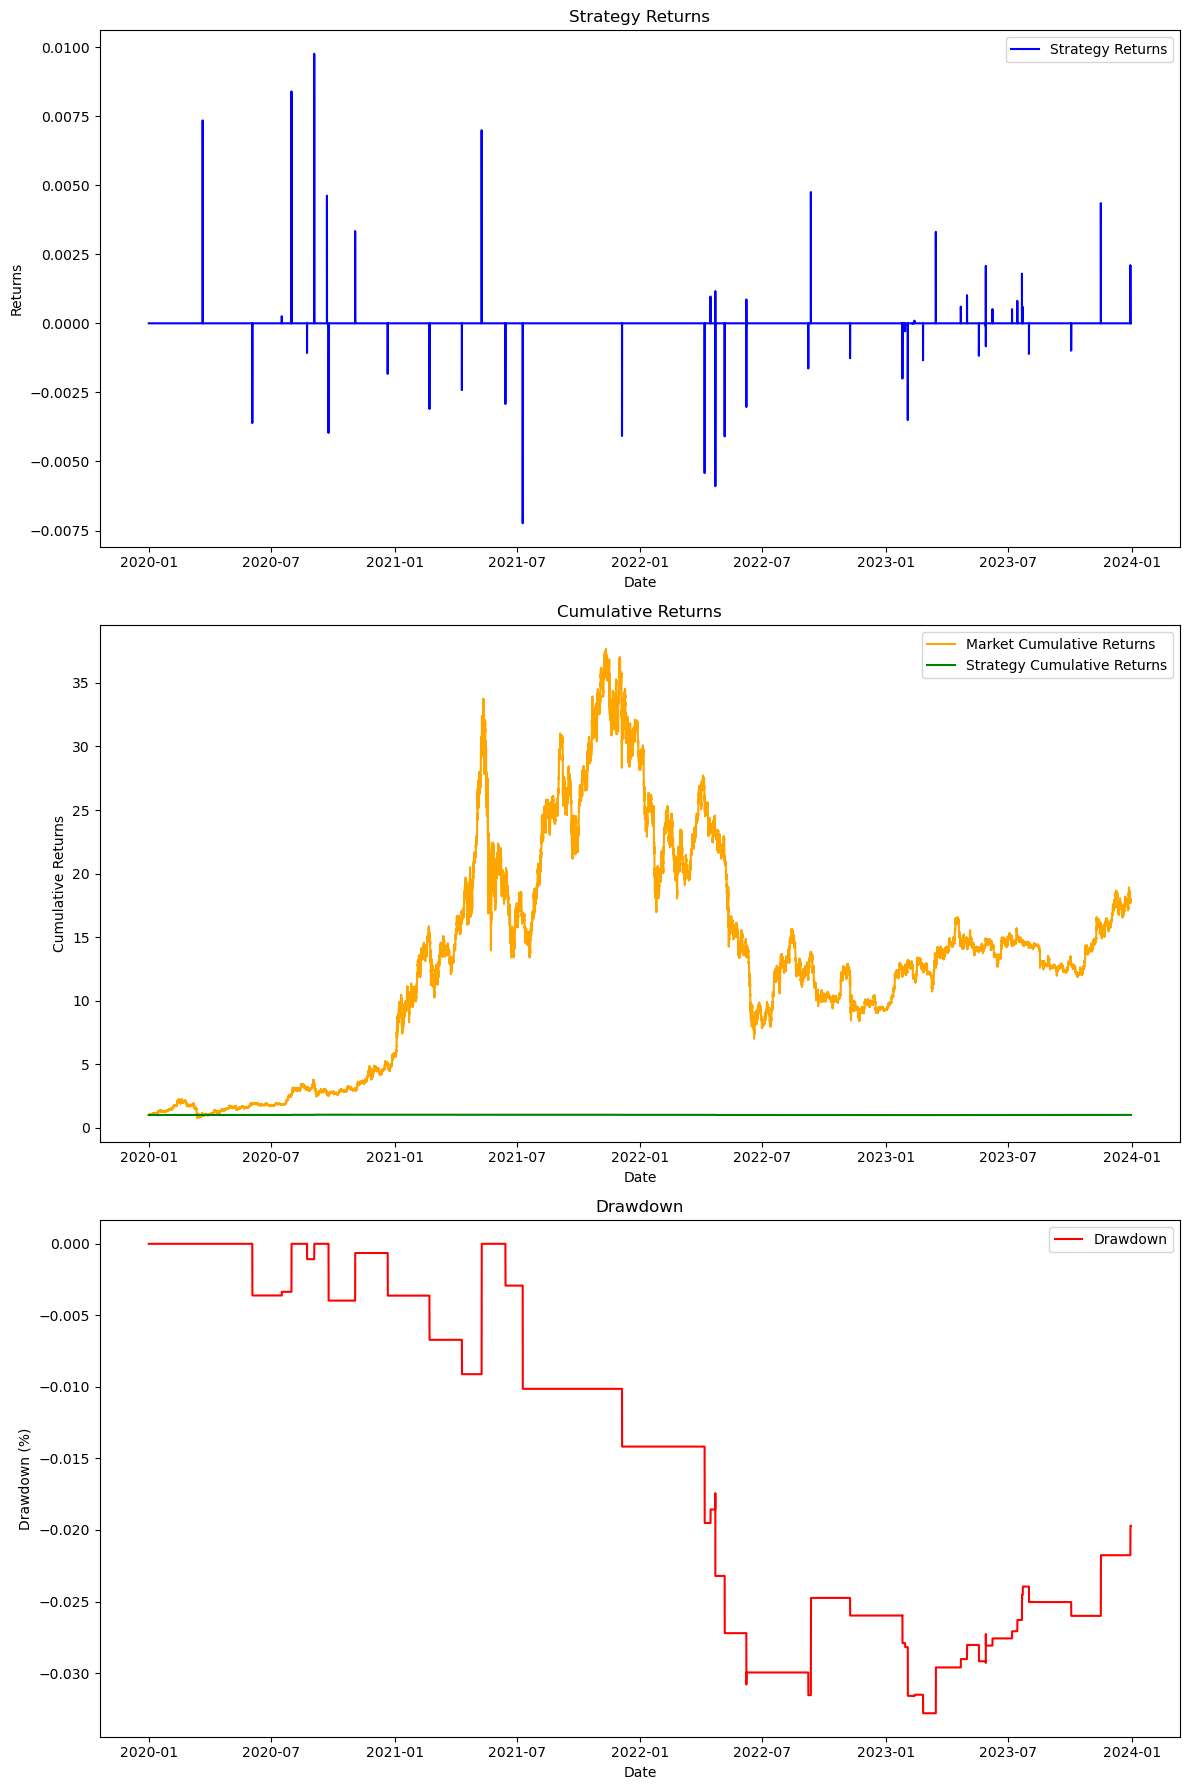

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("ETHresults.csv")
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)


data['returns'] = data['close'].pct_change()
data['strategy_returns'] = data['Signal'].shift(1) * data['returns'] 

data['cumulative_market_returns'] = (1 + data['returns']).cumprod()
data['cumulative_strategy_returns'] = (1 + data['strategy_returns']).cumprod()

data['cum_max'] = data['cumulative_strategy_returns'].cummax()
data['drawdown'] = data['cumulative_strategy_returns'] / data['cumulative_strategy_returns'].cummax() - 1

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))


ax1.plot(data.index, data['strategy_returns'], color="blue", label="Strategy Returns")
ax1.set_title("Strategy Returns")
ax1.set_xlabel("Date")
ax1.set_ylabel("Returns")
ax1.legend()

ax2.plot(data.index, data['cumulative_market_returns'], label="Market Cumulative Returns", color="orange")
ax2.plot(data.index, data['cumulative_strategy_returns'], label="Strategy Cumulative Returns", color="green")
ax2.set_title("Cumulative Returns")
ax2.set_xlabel("Date")
ax2.set_ylabel("Cumulative Returns")
ax2.legend()

# 3. Plot Drawdown
ax3.plot(data.index, data['drawdown'], color="red", label="Drawdown")
ax3.set_title("Drawdown")
ax3.set_xlabel("Date")
ax3.set_ylabel("Drawdown (%)")
ax3.legend()

plt.tight_layout()
plt.show()
